### Alunos: João Pedro Banhato Pereira; Pedro de Araujo Bhering Bittencourt
### Matrícula: 202165506B; 202165114B

# Relatório e Código do Trabalho Final de MAC023 - Mecânica das Estruturas

- Este trabalho contém o código utilizado para contemplar a análise e cálculo de modelos estruturais reticulados bidimensionais (formados por barras e unidas por nós) com elementos de seção constantes;

- Além disso, há uma descrição do funcionamento do programa, que abrange a validação dos exemplos utilizados e pontuais limitações.

### Orientações para inserção de dados em planilha:

#### Organização da Planilha

A planilha possui 6 tabelas: **Nós, Barras, Estrutura, Forças Pontuais, Forças Distribuídas, Forças Lineares**, cada uma organizada com as seguintes colunas:

##### Nós
- **X, Y:** Coordenadas \(X\) e \(Y\) do nó, em metros (m).
- **RX, RY, MZ:** Valores binários (0 ou 1) que indicam se o apoio existe (caso algum desses valores seja diferente de 0).  
  Ex.: 1º gênero (1, 0, 0), 2º gênero (1, 1, 0) e 3º gênero (1, 1, 1).

##### Barras
- **NO1, NO2:** Índices (1, 2, 3, ... , N) dos nós que formam a barra.
- **E, NU:** Módulo de elasticidade do material (\(KN/m^2\)) e coeficiente de Poisson, respectivamente.
- **SEC:** Indica se a seção transversal da barra é retangular (1) ou tipo I (2).
- **b, d:** Largura e altura da seção, em metros (m).
- **h, tw:** Utilizados somente para seção tipo I, representam, respectivamente, a altura total da seção e a espessura da alma, em metros.

##### Estrutura
- **TIPO:** Indica a estrutura representada, assumindo os valores:  
  1 (treliça plana), 2 (pórtico plano) e 3 (viga).
- **DIM:** Sempre indicado por 2, pois neste trabalho tratamos apenas de estruturas planas, em duas dimensões.

##### Forças Pontuais
- **X, Y:** Coordenadas do ponto onde a força ou momento é aplicado, em metros.
- **FX, FY, MZ:** Intensidade da força (KN) ou momento (KN·m) aplicado no ponto.

##### Forças Distribuídas
- **Módulo:** Intensidade do carregamento (KN/m).
- **X inicial, X final, Y inicial, Y final:** Coordenadas que posicionam o carregamento, em metros.

##### Forças Lineares
- **Módulo Inicial, Módulo Final:** Intensidades inicial e final do carregamento triangular (KN/m).
- **X inicial, X final, Y inicial, Y final:** Coordenadas que posicionam o carregamento triangular, em metros.


#### **Recomendações na criação da planilha:**
- Nó: todo ponto onde há apoio ou fim da barra;
- Boa prática: na inserção de nós nas barras, inserir nós consecutivos;
- Ao inserir E, a conversão de *KN/m^2* para *MPa* é *0.001*.

##Bibliotecas

Aqui se encontram as bibliotecas utilizadas para nos auxiliar na execução do trabalho e suas principais contribuições.

In [ ]:
import numpy as np                          # operações matemáticas, manipular arrays e sistemas lineares
import matplotlib.pyplot as plt             # gráficos
import pandas as pd                         # leitura de tabelas
from google.colab import files              # upload de tabelas
import re                                   # prints simbólicos
import sympy as sp                          # prints simbólicos
from IPython.display import display, Math   # prints simbólicos

## Print com Latex

Função auxiliar que facilita a visualização de vetores e matrizes em formato LaTeX.

In [ ]:
def print_latex(name, var, vetor=False):
    name = re.sub(r"_(\w+)", r"_{\1}", name)
    matrix = sp.Matrix(var)
    if vetor:
        if matrix.cols == 1:
            matrix = matrix.T
    display(Math(f"{name} = {sp.latex(matrix)}"))

##Leitura dos dados

Seção do código responsável por ler a planilha do arquivo Excel.

In [ ]:
# Importando a planilha
uploaded = files.upload()

Saving portico-outro.xlsx to portico-outro (1).xlsx


In [ ]:
arquivo = list(uploaded.keys())[0] # Recupera o nome do arquivo

## Adquirindo a estrutura por meio da leitura de cada tabela:

# Nos:
nos = pd.read_excel(arquivo, sheet_name='Nós')
nos.index +=1
nos.fillna(0, inplace=True)

# Barras:
barras = pd.read_excel(arquivo, sheet_name='Barras')
barras.index +=1
barras.fillna(0, inplace=True)

# Estrutura:
estrutura = pd.read_excel(arquivo, sheet_name='Estrutura')
estrutura.index +=1
estrutura.fillna(0, inplace=True)

# Forças pontuais:
forcas_pontuais = pd.read_excel(arquivo, sheet_name='Forças Pontuais')

# Forças distribuidas:
forcas_distribuidas = pd.read_excel(arquivo, sheet_name='Forças Distribuídas')

# Forças lineares:
forcas_lineares = pd.read_excel(arquivo, sheet_name='Forças Lineares')

##Informações pontuais do modelo

Realiza a leitura e impressão das variáveis de controle de dados do modelo.

In [ ]:
# Número de nos
nno = len(nos)
print('Número de nós na estrutura: ' + str(nno))

# Número de barras
nnel = len(barras)
print('Número de elementos na estrutura: ' + str(nnel))

# Número de nos por elemento
nnoel = sum(1 for coluna in barras.columns if re.match(r'NO\d+', coluna))
print('Número de nós por elemento: ' + str(nnoel))

# Variável que indica se é: TRELIÇA, PÓRTICO OU VIGA
itypestruct = estrutura.iloc[0, 0]
ndofn = 0

if itypestruct == 1: # TRELIÇA
  itypestruct = 'TRELICA'
  ndofn = 2
  print('Tipo da estrutura: Treliça plana')
  print('Número de graus de liberdade por nó: ' + str(ndofn))

elif itypestruct == 2: # PÓRTICO
  itypestruct = 'PORTICO'
  ndofn = 3
  print('Tipo da estrutura: Pórtico plano')
  print('Número de graus de liberdade por nó: ' + str(ndofn))

elif itypestruct == 3: # VIGA
  itypestruct = 'VIGA'
  ndofn = 2
  print('Tipo da estrutura: Viga')
  print('Número de graus de liberdade por nó: ' + str(ndofn))

# Número de materiais distintos
materiais = barras[['E']]
materiais_distintos = materiais.drop_duplicates()
ntm = len(materiais_distintos)
print('Número de materiais distintos: ' + str(ntm))

# Número de seções distintos
nts = barras['SEC'].nunique()
print(f"Número de tipos de seção distintos: {nts}")

# Número de dimensões
ndim = estrutura.iloc[0, 1]
print('Número de dimensões: ' + str(ndim))

Número de nós na estrutura: 6
Número de elementos na estrutura: 6
Número de nós por elemento: 2
Tipo da estrutura: Pórtico plano
Número de graus de liberdade por nó: 3
Número de materiais distintos: 1
Número de tipos de seção distintos: 1
Número de dimensões: 2


##Informações Gerais

Seção de controle para verificar se os dados foram corretamente importados da planilha.

In [ ]:
print(nos)
print('')
print(barras)
print('')
print(estrutura)
print('')
print(forcas_pontuais)
print('')
print(forcas_distribuidas)
print('')
print(forcas_lineares)

   X  Y  RX  RY  MZ
1  0  0   1   1   1
2  2  2   0   0   0
3  2  0   1   1   1
4  4  4   0   0   0
5  4  2   0   0   0
6  4  0   1   1   1

   NO1  NO2         E   NU  SEC    b    d  h  tw
1    1    2  32000000  0.5    1  0.2  0.7  0   0
2    2    3  32000000  0.5    1  0.2  0.7  0   0
3    2    4  32000000  0.5    1  0.2  0.7  0   0
4    2    5  32000000  0.5    1  0.2  0.7  0   0
5    4    5  32000000  0.5    1  0.2  0.7  0   0
6    5    6  32000000  0.5    1  0.2  0.7  0   0

   TIPO  DIM
1     2    2

     X   Y   FX   FY  MZ
0  0.5  0.5   0  100   0
1  3.0  3.0 -80    0  50

   Módulo  X Inicial  X Final  Y Inicial  Y Final
0     -30          4        4          0        2

   Módulo Inicial  Módulo Final  X Inicial  X Final  Y Inicial  Y Final
0               0            10          2        4          2        2


##Desenhando estrutura

Desenho simples da estrutura para verificar se está conforme preenchido com os dados.

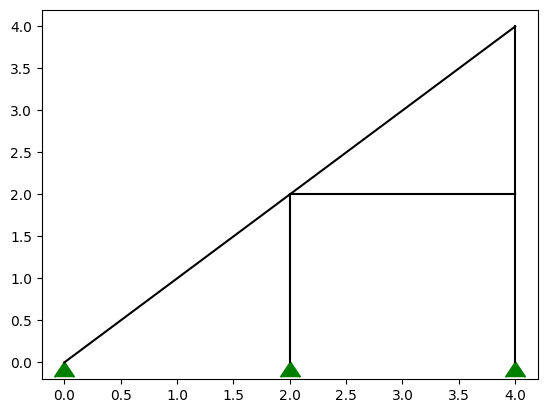

In [ ]:
for barra in barras.index:
    # Nós que compoem as barras
    NO1, NO2= barras.loc[barra, ['NO1', 'NO2']]

    # Coordenadas dos nós
    x1,y1 = nos.loc[NO1, ['X', 'Y']]
    x2,y2 = nos.loc[NO2, ['X', 'Y']]

    X = np.array ([x1, x2])
    Y = np.array ([y1, y2])

    plt.plot(X, Y, color = 'black')

for no in nos.index:
    # Importando dados dos nós
    X, Y, RX, RY, MZ = nos.loc[no]

    if itypestruct == 'TRELICA':
      # Desenhando rótulas
      plt.scatter(X, Y, s = 50, color = 'black', marker="o")

    # Desenhando apoios
    if RX == 1 and RY == 0 and MZ == 0: # Primeiro gênero
      plt.scatter(X, Y, s = 200, color = 'blue', marker=5)

    if RX == 1 and RY == 1 and MZ == 0: # Segundo gênero
      plt.scatter(X, Y, s = 200, color = 'red', marker=6)

    if RX == 1 and RY == 1 and MZ == 1: # Terceiro gênero
      plt.scatter(X, Y, s = 200, color = 'green', marker=6)

plt.show()

##Cálculo da Matriz de Rigidez da Estrutura

Performa a montagem da matriz global de rigidez, de acordo com o tipo de estrutura, além de fornecer as matrizes locais de cada elemento.

###Montando matriz da treliça plana

- Para cada barra, são calculados o comprimento, seno, cosseno e as propriedades geométricas (área e momento de inércia);

- A matriz de rigidez local é construída para o elemento (considerando somente forças axiais) e depois a transformação de rotação para converter para o referencial global;

- O vetor LM mapeia os graus de liberdade de cada nó e as contribuições de cada barra são somadas na matriz global de rigidez.

In [ ]:
def monta_matriz_trelica(Kls, LMs):
    Ls = []
    senos = []
    cossenos = []
    areas = []
    momentos_inercia = []

    for barra in barras.index:
      #Nós que compoem as barras
      NO1, NO2= barras.loc[barra, ['NO1', 'NO2']]

      #Determinação das coordenadas
      x1,y1 = nos.loc[NO1, ['X', 'Y']]
      x2,y2 = nos.loc[NO2, ['X', 'Y']]

      #Projeções nos eixos X e Y
      LX = x2 - x1
      LY = y2 - y1
      L = np.sqrt(LX**2 + LY**2)

      #seno e cosseno
      seno = LY/L
      coss = LX/L

      secao = barras.loc[barra, 'SEC']
      A = 0
      I = 0

      if secao == 1:  # Seção retangular
            b = barras.loc[barra, 'b']  # Largura da seção
            d = barras.loc[barra, 'd']  # Altura da seção

            A = b * d  # Área da seção retangular
            I = (b * d**3) / 12  # Momento de inércia da seção retangular

      elif secao == 2:  # Seção I
          b = barras.loc[barra, 'b']  # Largura das abas
          d = barras.loc[barra, 'd']  # Altura das abas
          tw = barras.loc[barra, 'tw']  # Largura da alma
          tf = barras.loc[barra, 'tf']  # Altura da alma

          # Cálculo da área da seção I
          A = 2 * b * tf + (d - 2*tf)*tw

          I_banzo = (b * tf**3) / 12 + b * tf * (d/2 - tf/2)**2

          I_alma = (tw * (d - 2*tf)**3) / 12

          I = 2 * I_banzo + I_alma

      #Pendurando as listas
      Ls.append(L)
      senos.append(seno)
      cossenos.append(coss)
      areas.append(A)
      momentos_inercia.append(I)

    barras['L'] = Ls
    barras['sen'] = senos
    barras['cos'] = cossenos
    barras['A'] = areas
    barras['I'] = momentos_inercia

    ### Montagem da matriz de rigidez
    #Pré alocando a matriz de rigidez global
    maxgl = ndofn*len(nos.index)
    K = np.zeros((maxgl, maxgl))

    for barra in barras.index:
      NO1 = barras.loc[barra, 'NO1']
      NO2 = barras.loc[barra, 'NO2']
      A = barras.loc[barra, 'A']
      E = barras.loc[barra, 'E']
      L = barras.loc[barra, 'L']
      sen = barras.loc[barra, 'sen']
      cos = barras.loc[barra, 'cos']

      #Matriz de rigidez no sistema local
      Kl = E*A/L*np.array([[ 1, 0,-1, 0],
                            [ 0, 0, 0, 0],
                            [-1, 0, 1, 0],
                            [ 0, 0, 0, 0]])
      print("Matriz Local da barra " + str(NO1) + "-" + str(NO2))
      print_latex('K_l', Kl)
      print()

      #Matriz de rotação
      Mrot = np.array([[ cos,  sen, 0, 0],
                        [-sen,  cos, 0, 0],
                        [0, 0,  cos, sen],
                        [0, 0, -sen, cos]])

      #Rotação da matriz de rigidez
      Klr = np.dot(np.dot(Mrot.T, Kl), Mrot)
      Kls.append(Klr)
      print("Matriz da barra " + str(NO1) + "-" + str(NO2) + " no referencial Global")
      print_latex('K_lr', Klr)
      print()

      gl1_x = 2*(NO1 - 1) #deslocamento X do nó NO1
      gl1_y = 2*(NO1 - 1) + 1 #deslocamento Y do nó NO1
      gl2_x = 2*(NO2 - 1) #deslocamento X do nó NO2
      gl2_y = 2*(NO2 - 1) + 1 #deslocamento Y do nó NO2

      LM = [gl1_x, gl1_y, gl2_x, gl2_y]
      LMs.append(LM)
      print("LM da barra " + str(NO1) + "-" + str(NO2) + ": ")
      print_latex('LM', LM, vetor = True)
      print()

      for i_local in range(4):
        I_global = LM[i_local]
        for j_local in range(4):
          J_global = LM[j_local]
          K[I_global, J_global] += Klr[i_local, j_local]

    return K, maxgl

###Montando matriz do pórtico plano

- Segue o mesmo sentido acima, com algumas ressalvas;
- A matriz de rigidez local contempla efeitos de flexão e momentos;
– O mapeamento dos graus de liberdade é feito considerando 3 graus de liberdade por nó.

In [ ]:
def monta_matriz_portico(Kls, LMs):
    Ls = []
    senos = []
    cossenos = []
    areas = []
    momentos_inercia = []

    for barra in barras.index:
      #Nós que compoem as barras
      NO1, NO2 = barras.loc[barra, ['NO1', 'NO2']]

      #Determinação das coordenadas
      x1,y1 = nos.loc[NO1, ['X', 'Y']]
      x2,y2 = nos.loc[NO2, ['X', 'Y']]

      #Projeções nos eixos X e Y
      LX = x2 - x1
      LY = y2 - y1
      L = np.sqrt(LX**2 + LY**2)

      #seno e cosseno
      seno = LY/L
      coss = LX/L

      secao = barras.loc[barra, 'SEC']
      A = 0
      I = 0

      if secao == 1:  # Seção retangular
            b = barras.loc[barra, 'b']  # Largura da seção
            d = barras.loc[barra, 'd']  # Altura da seção

            A = b * d  # Área da seção retangular
            I = (b * d**3) / 12  # Momento de inércia da seção retangular

      elif secao == 2:  # Seção I
          b = barras.loc[barra, 'b']  # Largura das abas
          d = barras.loc[barra, 'd']  # Altura das abas
          tw = barras.loc[barra, 'tw']  # Largura da alma
          tf = barras.loc[barra, 'tf']  # Altura da alma

          # Cálculo da área da seção I
          A = 2 * b * tf + (d - 2*tf)*tw

          I_banzo = (b * tf**3) / 12 + b * tf * (d/2 - tf/2)**2

          I_alma = (tw * (d - 2*tf)**3) / 12

          I = 2 * I_banzo + I_alma

      #Pendurando as listas
      Ls.append(L)
      senos.append(seno)
      cossenos.append(coss)
      areas.append(A)
      momentos_inercia.append(I)

    barras['L'] = Ls
    barras['sen'] = senos
    barras['cos'] = cossenos
    barras['A'] = areas
    barras['I'] = momentos_inercia


    ###Montagem da matriz de rigidez
    #Pré alocando a matriz de rigidez global
    maxgl = ndofn*len(nos.index)
    K = np.zeros((maxgl, maxgl))

    for barra in barras.index:
      NO1 = barras.loc[barra, 'NO1']
      NO2 = barras.loc[barra, 'NO2']
      A = barras.loc[barra, 'A']
      E = barras.loc[barra, 'E']
      L = barras.loc[barra, 'L']
      sen = barras.loc[barra, 'sen']
      cos = barras.loc[barra, 'cos']
      I = barras.loc[barra, 'I']

      #Matriz de rigidez no sistema local
      Kl = np.array([[ E*A/L, 0, 0, -E*A/L, 0, 0],
                     [ 0, 12*E*I/L**3, 6*E*I/L**2, 0, -12*E*I/L**3, 6*E*I/L**2],
                     [0, 6*E*I/L**2,4*E*I/L, 0, -6*E*I/L**2, 2*E*I/L],
                     [-E*A/L, 0, 0, E*A/L, 0, 0],
                     [0, -12*E*I/L**3, -6*E*I/L**2, 0, 12*E*I/L**3, -6*E*I/L**2],
                     [0, 6*E*I/L**2, 2*E*I/L, 0, -6*E*I/L**2, 4*E*I/L]])
      print("Matriz Local da barra " + str(NO1) + "-" + str(NO2))
      print_latex('K_l', Kl)
      print()

      #Matriz de rotação
      Mrot = np.array([[ cos,  sen, 0, 0, 0, 0],
                        [-sen,  cos, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0],
                        [0, 0, 0, cos, sen, 0],
                        [0, 0, 0, -sen, cos, 0],
                        [0, 0, 0, 0, 0, 1]])

      #Rotação da matriz de rigidez
      Klr = np.dot(np.dot(Mrot.T, Kl), Mrot)
      Kls.append(Klr)
      gl1_x = 3*(NO1 - 1)     #deslocamento X do nó NO1
      gl1_y = 3*(NO1 - 1) + 1  #deslocamento Y do nó NO1
      gl1_z = 3*(NO1 - 1) + 2 #momento Z do nó NO1
      gl2_x = 3*(NO2 - 1)     #deslocamento X do nó NO2
      gl2_y = 3*(NO2 - 1) + 1  #deslocamento Y do nó NO2
      gl2_z = 3*(NO2 - 1) + 2 #momento Z do nó NO2

      LM = [gl1_x, gl1_y, gl1_z, gl2_x, gl2_y, gl2_z]
      LMs.append(LM)
      print("LM da barra " + str(NO1) + "-" + str(NO2) + ": ")
      print_latex('LM', LM, vetor = True)
      print()

      for i_local in range(6):
        I_global = LM[i_local]
        for j_local in range(6):
          J_global = LM[j_local]
          K[I_global, J_global] += Klr[i_local, j_local]

    return K, maxgl

###Montando matriz da viga plana

- Segue o mesmo sentido indicado, porém sem rotação;

- Além disso, os graus de liberdade em LM são mapeados considerando 2 por nó (deslocamento vertical e rotação).

In [ ]:
def monta_matriz_viga(Kls, LMs):
  Ls = []
  areas = []
  momentos_inercia = []

  for barra in barras.index:
      #Nós que compoem as barras
      NO1, NO2= barras.loc[barra, ['NO1', 'NO2']]

      #Determinação das coordenadas
      x1,y1 = nos.loc[NO1, ['X', 'Y']]
      x2,y2 = nos.loc[NO2, ['X', 'Y']]

      #Projeções nos eixos X e Y
      LX = x2 - x1
      LY = y2 - y1
      L = np.sqrt(LX**2 + LY**2)

      secao = barras.loc[barra, 'SEC']
      A = 0
      I = 0

      if secao == 1:  # Seção retangular
            b = barras.loc[barra, 'b']  # Largura da seção
            d = barras.loc[barra, 'd']  # Altura da seção

            A = b * d  # Área da seção retangular
            I = (b * d**3) / 12  # Momento de inércia da seção retangular

      elif secao == 2:  # Seção I
          b = barras.loc[barra, 'b']  # Largura das abas
          d = barras.loc[barra, 'd']  # Altura das abas
          tw = barras.loc[barra, 'tw']  # Largura da alma
          tf = barras.loc[barra, 'tf']  # Altura da alma

          # Cálculo da área da seção I
          A = 2 * b * tf + (d - 2*tf)*tw

          I_banzo = (b * tf**3) / 12 + b * tf * (d/2 - tf/2)**2

          I_alma = (tw * (d - 2*tf)**3) / 12

          I = 2 * I_banzo + I_alma

      #Pendurando as listas
      Ls.append(L)
      areas.append(A)
      momentos_inercia.append(I)

  barras['L'] = Ls
  barras['A'] = areas
  barras['I'] = momentos_inercia
  maxgl = ndofn*len(nos.index)
  K = np.zeros((maxgl, maxgl))

  for barra in barras.index:
      NO1 = barras.loc[barra, 'NO1']
      NO2 = barras.loc[barra, 'NO2']
      A = barras.loc[barra, 'A']
      E = barras.loc[barra, 'E']
      L = barras.loc[barra, 'L']
      I = barras.loc[barra, 'I']

      #Matriz de rigidez no sistema local
      Kl = np.array([[ 12*E*I/L**3, 6*E*I/L**2,-12*E*I/L**3, 6*E*I/L**2],
                            [ 6*E*I/L**2, 4*E*I/L, -6*E*I/L**2, 2*E*I/L],
                            [-12*E*I/L**3, -6*E*I/L**2, 12*E*I/L**3, -6*E*I/L**2],
                            [ 6*E*I/L**2, 2*E*I/L, -6*E*I/L**2, 4*E*I/L]])
      Kls.append(Kl)
      print("Matriz Local da barra " + str(NO1) + "-" + str(NO2))
      print_latex('K_l', Kl)
      print()

      gl1_y = 2*(NO1 - 1)     #deslocamento Y do nó NO1
      gl1_z = 2*(NO1 - 1) + 1 #momento Z do nó NO1
      gl2_y = 2*(NO2 - 1)     #deslocamento Y do nó NO2
      gl2_z = 2*(NO2 - 1) + 1 #momento Z do nó NO2

      LM = [gl1_y, gl1_z, gl2_y, gl2_z]
      LMs.append(LM)
      print("LM da barra " + str(NO1) + "-" + str(NO2) + ": ")
      print_latex('LM', LM, vetor = True)
      print()

      for i_local in range(4):
        I_global = LM[i_local]
        for j_local in range(4):
          J_global = LM[j_local]
          K[I_global, J_global] += Kl[i_local, j_local]

  return K, maxgl

###Escolhendo função adequada

Escolhe para qual das três funções acima irá direcionar.

In [ ]:
# De acordo com o tipo da estrutura, monta a matriz de rigidez global
def monta_matriz_global(itypestruct, Kls, LMs):
  if itypestruct == 'TRELICA': #Treliça plana
    K, maxgl = monta_matriz_trelica(Kls, LMs)
    return K, maxgl

  elif itypestruct == 'PORTICO': #Pórtico plano
    K, maxgl = monta_matriz_portico(Kls, LMs)
    return K, maxgl

  elif itypestruct == 'VIGA': #Viga
    K, maxgl = monta_matriz_viga(Kls, LMs)
    return K, maxgl

  return 0, 0

###Montando matriz da estrutura

Módulo principal dessa seção.

In [ ]:
Kls = [] #Vetor que armazenas as matrizes globais
LMs = []
Kg, maxgl = monta_matriz_global(itypestruct, Kls, LMs)
print("Matriz de rigidez global Kg:")
print_latex('Kg', Kg)

Matriz Local da barra 1-2


<IPython.core.display.Math object>


LM da barra 1-2: 


<IPython.core.display.Math object>


Matriz Local da barra 2-3


<IPython.core.display.Math object>


LM da barra 2-3: 


<IPython.core.display.Math object>


Matriz Local da barra 2-4


<IPython.core.display.Math object>


LM da barra 2-4: 


<IPython.core.display.Math object>


Matriz Local da barra 2-5


<IPython.core.display.Math object>


LM da barra 2-5: 


<IPython.core.display.Math object>


Matriz Local da barra 4-5


<IPython.core.display.Math object>


LM da barra 4-5: 


<IPython.core.display.Math object>


Matriz Local da barra 5-6


<IPython.core.display.Math object>


LM da barra 5-6: 


<IPython.core.display.Math object>


Matriz de rigidez global Kg:


<IPython.core.display.Math object>

##Montando o Vetor de Cargas

Sistema de cargas atuantes na estrutura.

###Funções da tabela de ações de engastamento perfeito

- Baseado no tipo de carregamento (força pontual, momento, carregamento distribuído ou linear) e na posição de aplicação na barra, calcula os efeitos (momentos e forças reativas).

- Consideramos os principais casos presentes na tabela de engastamento perfeito da apostila disponibilizada.

In [ ]:
#Força vertical pontual
def caso_1(P, a, b, L):
  Ma = P * a * b**2 / L**2
  Mb = -P * a**2 * b / L**2
  Va = P * b**2 * (3*a + b) / L**3
  Rb = P * a**2 * (a + 3*b) / L**3
  return Ma, Mb, Va, Rb

#Momento fletor
def caso_2(M, a, b, L):
  Ma = M * b * (2*a - b) / L**2
  Mb = M * a * (2*b - a) / L**2
  Ra = 6 * M * a * b / L**3
  Rb = -Ra
  return Ma, Mb, Ra, Rb

#Força horizontal pontual
def caso_3(P, a, b, L):
  Va = -P * b / L
  Vb = -P * a/ L

  return Va, Vb

#Carregamento distribúido
def caso_4(q, a, L):
  Ma = q * L**2 / 12
  Mb = -Ma
  Va = q*L/2
  Vb = Va

  return Ma, Mb, Va, Vb

#Carregamento distribuido por pedaco da barra:
def caso_5(q, a, L):
  Ma = q * a**2 * (6 * L**2 - 8*a*L + 3 *a **2) / (12*L**2)
  Mb = - q * a**3 * (4 * L - 3 * a) / (12 * L**2)
  Va = q * a * (2* L**3 - 2 * a**2 * L + a**3) / (2 * L**3)
  Vb = q * a**3 * (2 * L - a) / (2 * L**3)
  return Ma, Mb, Va, Vb

#Carregamento Linear
def caso_6(q, L):
  Ma = q * L**2 / 30
  Mb = - q * L**2 / 20
  Va = 3 * q * L / 20
  Vb = 7 * q * L / 20

  return Ma, Mb, Va, Vb

###Ações de engastamento perfeito

In [ ]:
A_ML = np.zeros((nnel, 2*ndofn)) #montando matriz

####Forças e momentos nos nós

- Monta o vetor $f_n$ de acordo com as cargas aplicadas diretamente no nó.

In [ ]:
#Força Pontual
forcas_pontuais = pd.read_excel(arquivo, sheet_name='Forças Pontuais')

f_n = np.zeros(maxgl)

copia_forcas = forcas_pontuais.copy()

for n in nos.index:
  Xn, Yn, _, _, _ = nos.loc[n]

  for f in forcas_pontuais.index:
    Xf, Yf, FX, FY, MZ = forcas_pontuais.loc[f]

    if Xn == Xf and Yn == Yf:
      if itypestruct == 'TRELICA':
        f_n[2*(n-1)] += FX
        f_n[2*(n-1)+1] += FY
      if itypestruct == 'PORTICO':
        f_n[3*(n-1)] += FX
        f_n[3*(n-1)+1] += FY
        f_n[3*(n-1)+2] += MZ
      if itypestruct == 'VIGA':
        f_n[2*(n-1)] += FY
        f_n[2*(n-1)+1] += MZ
      forcas_pontuais.drop(f, inplace=True)

print_latex('f_n', f_n)

<IPython.core.display.Math object>

#### Função que verifica se a força está na barra

Determina se a força está presente na geometria da barra.

In [ ]:
# Para forças nodais
def forca_barra(Xf, Yf, x1, y1, x2, y2, tol=1e-5):
    def ponto_na_barra(X, Y):
        if abs(x2 - x1) < tol:
            # Barra vertical
            return abs(X - x1) < tol and min(y1, y2) - tol <= Y <= max(y1, y2) + tol
        else:
            a = (y2 - y1) / (x2 - x1)
            b = y1 - a * x1
            return abs(Y - (a * X + b)) < tol and min(x1, x2) - tol <= X <= max(x1, x2) + tol

    return ponto_na_barra(Xf, Yf)

# Para carregamentos
def forca_barra_distribuida(Xi, Yi, Xf, Yf, x1, y1, x2, y2, tol=1e-5):
    def ponto_na_barra(X, Y):
        # Verifica se o ponto está na reta
        if abs(x2 - x1) < tol:
            # Barra vertical
            return abs(X - x1) < tol and min(y1, y2) - tol <= Y <= max(y1, y2) + tol
        else:
            a = (y2 - y1) / (x2 - x1)
            b = y1 - a * x1
            return abs(Y - (a * X + b)) < tol and min(x1, x2) - tol <= X <= max(x1, x2) + tol

    # Verifica se os dois pontos da força estão no segmento da barra
    return ponto_na_barra(Xi, Yi) and ponto_na_barra(Xf, Yf)

####Forças e momentos pontuais nas barras

Ações nas extremidades dos elementos, devido a forças e momentos pontuais nas barras.

In [ ]:
Va_x = Vb_x = Va_y = Vb_y = Va_z = Vb_z = Ma_x = Mb_x = Ma_y = Mb_y = Ma_z = Mb_z = 0

n_barra = 0

for barra in barras.index:
  NO1, NO2 = barras.loc[barra, ['NO1', 'NO2']]
  x1,y1 = nos.loc[NO1, ['X', 'Y']]
  x2,y2 = nos.loc[NO2, ['X', 'Y']]
  NO1 = int(NO1)
  NO2 = int(NO2)

  LX = x2 - x1
  LY = y2 - y1
  L = np.sqrt(LX**2 + LY**2)

  seno = LY/L
  coss = LX/L

  m_i = n_barra
  m_j = 0
  n_barra += 1

  for f in forcas_pontuais.index:
    Xf, Yf, FX, FY, MZ = forcas_pontuais.loc[f]
    #Tratar barra em pé ou inclinada

    if forca_barra(Xf, Yf, x1, y1, x2, y2):
      ax = Xf - x1
      ay = Yf - y1

      a = np.sqrt(ax**2 + ay**2)
      b = L - a

      if itypestruct == 'PORTICO':
        # Caso 1: barra horizontal (y1 == y2)
        if y1 == y2:
            if FY != 0:
                # A função caso_1 distribui a carga transversal (nesse caso, vertical)
                Ma_y, Mb_y, Va_y, Vb_y = caso_1(-FY, a, b, L)
            if FX != 0:
                # A função caso_3 distribui a carga axial
                Va_x, Vb_x = caso_3(FX, a, b, L)
            if MZ != 0:
                # A função caso_2 trata o momento aplicado
                Ma_z, Mb_z, Va_z, Vb_z = caso_2(MZ, a, b, L)

            A_ML[m_i, m_j]   = Va_x
            A_ML[m_i, m_j+1] = Va_y + Va_z
            A_ML[m_i, m_j+2] = Ma_y + Mb_z
            A_ML[m_i, m_j+3] = Vb_x
            A_ML[m_i, m_j+4] = Vb_y + Vb_z
            A_ML[m_i, m_j+5] = Mb_y + Mb_z

            forcas_pontuais.drop(f, inplace=True)

        # Caso 2: barra vertical (x1 == x2)
        elif x1 == x2:
            # Agora FX é a carga lateral que gera flexão na vertical;
            if FX != 0:
                # usamos caso_1 para distribuir a carga de flexão
                if y1 < y2:
                  Ma_x, Mb_x, Va_x, Vb_x = caso_1(FX, a, b, -L)
                else:
                  Ma_x, Mb_x, Va_x, Vb_x = caso_1(-FX, a, b, L)
            if FY != 0:
                Va_y, Vb_y = caso_3(FY, a, b, L)
                # FY atua na direção axial (vertical) da coluna
            if MZ != 0:
                if y1 < y2:
                  Ma_z, Mb_z, Va_z, Vb_z = caso_2(MZ, a, b, -L)
                else:
                  Ma_z, Mb_z, Va_z, Vb_z = caso_2(-MZ, a, b, L)

            A_ML[m_i, m_j]   = Va_x + Va_z   # força axial (vertical) no NO1
            A_ML[m_i, m_j+1] = Va_y          # esforço de flexão resultante em NO1
            A_ML[m_i, m_j+2] = Ma_x + Ma_z   # momento em NO1 (a carga axial não gera momento)
            A_ML[m_i, m_j+3] = Vb_x + Vb_z   # força axial no NO2
            A_ML[m_i, m_j+4] = Vb_y
            A_ML[m_i, m_j+5] = Mb_x + Mb_z

            forcas_pontuais.drop(f, inplace=True)

        # Caso 3: barra inclinada (nem horizontal nem vertical)
        else:
            F_axial, F_trans = 0, 0

            F_axial += FX * coss
            F_trans += FX * seno

            F_axial += FY * seno
            F_trans += -FY * coss

            if F_axial != 0:
                Va_axial, Vb_axial = caso_3(F_axial, a, b, L)
            else:
                Va_axial, Vb_axial = 0, 0
            if F_trans != 0:
                Ma_trans, Mb_trans, Va_trans, Vb_trans = caso_1(F_trans, a, b, L)
            else:
                Ma_trans = Mb_trans = Va_trans = Vb_trans = 0
            if MZ != 0:
                Ma_z, Mb_z, Va_z, Vb_z = caso_2(MZ, a, b, L)
            else:
                Ma_z = Mb_z = Va_z = Vb_z = 0

            # Monta os termos na matriz A_ML considerando que:
            # - A contribuição axial vem de F_axial
            # - A flexão é gerada pela carga transversal (F_trans) e pelo momento MZ
            A_ML[m_i, m_j]   = Va_axial * seno - Va_trans * seno - Va_z * seno      # força axial (vertical) no NO1
            A_ML[m_i, m_j+1] = Va_trans * coss + Va_axial *coss + Va_z * coss  # esforço de flexão resultante em NO1
            A_ML[m_i, m_j+2] = Ma_trans + Ma_z   # momento em NO1 (a carga axial não gera momento)
            A_ML[m_i, m_j+3] = Vb_axial * seno - Vb_trans * seno - Vb_z * seno       # força axial no NO2
            A_ML[m_i, m_j+4] = Vb_trans *coss + Vb_axial * coss + Vb_z * coss
            A_ML[m_i, m_j+5] = Mb_trans + Mb_z

            forcas_pontuais.drop(f, inplace=True)

      if itypestruct == 'VIGA': # viga
        if FY != 0:
          Ma_y, Mb_y, Va_y, Vb_y = caso_1(-FY, a , b, L)
        if FX != 0:
            Va_x, Vb_x = caso_3(FX, a, b, L)
        if MZ != 0:
           Ma_z, Mb_z, Va_z, Vb_z = caso_2(MZ, a, b, L)

        A_ML[m_i,m_j] = Va_y + Va_z
        A_ML[m_i,m_j+1] = Ma_y + Ma_z
        A_ML[m_i,m_j+2] = Vb_y + Vb_z
        A_ML[m_i,m_j+3] = Mb_y + Mb_z

        forcas_pontuais.drop(f, inplace=True)

print(f"Forças e momentos pontuais em A_ML:")
print_latex('A_ML', A_ML)

Forças e momentos pontuais em A_ML:


<IPython.core.display.Math object>

####Forças distribuídas nas barras

Ações nas extremidades dos elementos, devido a forças distribuídas nas barras.

In [ ]:
forcas_distribuidas = pd.read_excel(arquivo, sheet_name='Forças Distribuídas')

Ma, Mb, Va, Vb = 0, 0, 0, 0

n_barra = 0

for barra in barras.index:
  NO1, NO2 = barras.loc[barra, ['NO1', 'NO2']]
  x1,y1 = nos.loc[NO1, ['X', 'Y']]
  x2,y2 = nos.loc[NO2, ['X', 'Y']]
  NO1 = int(NO1)
  NO2 = int(NO2)

  LX = x2 - x1
  LY = y2 - y1
  L = np.sqrt(LX**2 + LY**2)

  seno = LY/L
  coss = LX/L

  m_i = n_barra
  m_j = 0
  n_barra += 1

  for f in forcas_distribuidas.index:
    modulo, Xi, Xf, Yi, Yf = forcas_distribuidas.loc[f]

    #Tratar barra em pé ou inclinada

    if forca_barra_distribuida(Xi, Yi, Xf, Yf, x1, y1, x2, y2): #Força está completamente na barra
      a_x = Xf - Xi
      a_y = Yf - Yi
      a = np.sqrt(a_x**2 + a_y**2)

      if itypestruct == 'PORTICO':
        if modulo != 0:
          # Caso 1: Barra horizontal (y1 == y2)
          if y1 == y2:
              if x1 == Xi and x2 == Xf:
                Ma, Mb, Va, Vb = caso_4(-modulo, a, L)
              else: # carregamento nao completo na barra
                if (x1 == Xi): # comeca na esq
                  Ma, Mb, Va, Vb = caso_5(-modulo, a, L)
                else: # comeca em outro lugar no meio da barra
                  Ma_total, Mb_total, Va_total, Vb_total = caso_5(-modulo, Xf - x1, L)
                  Ma_removido, Mb_removido, Va_removido, Vb_removido = caso_5(-modulo, Xi - x1, L)
                  Ma = Ma_total - Ma_removido
                  Mb = Mb_total - Mb_removido
                  Va = Va_total - Va_removido
                  Vb = Vb_total - Vb_removido

              # Monta os termos na matriz de reações
              A_ML[m_i, m_j]   = 0
              A_ML[m_i, m_j+1] = Va
              A_ML[m_i, m_j+2] = Ma
              A_ML[m_i, m_j+3] = 0
              A_ML[m_i, m_j+4] = Vb
              A_ML[m_i, m_j+5] = Mb

              forcas_distribuidas.drop(f, inplace=True)

          # Caso 2: Barra vertical (x1 == x2)
          elif x1 == x2:
            if y1 > y2:
              if y1 == Yf and y2 == Yi:
                Ma, Mb, Va, Vb = caso_4(-modulo, a, L)
              else: # carregamento nao completo na barra
                if (y2 == Yi): # comeca em baixo
                  Ma, Mb, Va, Vb = caso_5(-modulo, a, L)
                else: # comeca em outro lugar no meio da barra
                  Ma_total, Mb_total, Va_total, Vb_total = caso_5(-modulo, Yf - y2, L)
                  Ma_removido, Mb_removido, Va_removido, Vb_removido = caso_5(-modulo, Yi - y2, L)
                  Ma = Ma_total - Ma_removido
                  Mb = Mb_total - Mb_removido
                  Va = Va_total - Va_removido
                  Vb = Vb_total - Vb_removido
            else:
              if y1 == Yi and y2 == Yf:
                Ma, Mb, Va, Vb = caso_4(modulo, a, -L)
              else: # carregamento nao completo na barra
                if (y1 == Yi): # comeca em baixo
                  Ma, Mb, Va, Vb = caso_5(modulo, a, -L)
                else: # comeca em outro lugar no meio da barra
                  Ma_total, Mb_total, Va_total, Vb_total = caso_5(modulo, Yf - y1, -L)
                  Ma_removido, Mb_removido, Va_removido, Vb_removido = caso_5(modulo, Yi - y1, -L)
                  Ma = Ma_total - Ma_removido
                  Mb = Mb_total - Mb_removido
                  Va = Va_total - Va_removido
                  Vb = Vb_total - Vb_removido


              # Monta os termos na matriz de reações
            A_ML[m_i, m_j]   = Va
            A_ML[m_i, m_j+1] = 0
            A_ML[m_i, m_j+2] = Ma
            A_ML[m_i, m_j+3] = Vb
            A_ML[m_i, m_j+4] = 0
            A_ML[m_i, m_j+5] = Mb

            forcas_distribuidas.drop(f, inplace=True)


      if itypestruct == 'VIGA': # viga deitada
        if modulo != 0: # carregamento completo na barra
          if x1 == Xi and x2 == Xf:
            Ma, Mb, Va, Vb = caso_4(-modulo, a, L)
          else: # carregamento nao completo na barra
            if (x1 == Xi): # comeca na esq
              Ma, Mb, Va, Vb = caso_5(-modulo, a, L)
            else: # comeca em outro lugar no meio da barra
              Ma_total, Mb_total, Va_total, Vb_total = caso_5(-modulo, Xf - x1, L)
              Ma_removido, Mb_removido, Va_removido, Vb_removido = caso_5(-modulo, Xi - x1, L)
              Ma = Ma_total - Ma_removido
              Mb = Mb_total - Mb_removido
              Va = Va_total - Va_removido
              Vb = Vb_total - Vb_removido

          A_ML[m_i,m_j] = Va
          A_ML[m_i,m_j+1] = Ma
          A_ML[m_i,m_j+2] = Vb
          A_ML[m_i,m_j+3] = Mb
          forcas_distribuidas.drop(f, inplace=True)

print(f"Forças distribuídas em A_ML:")
print_latex('A_ML', A_ML)

Forças distribuídas em A_ML:


<IPython.core.display.Math object>

####Forças Lineares nas barras

Ações nas extremidades dos elementos, devido a forças lineares nas barras.

In [ ]:
forcas_lineares = pd.read_excel(arquivo, sheet_name='Forças Lineares')

Ma, Mb, Va, Vb = 0, 0, 0, 0
n_barra = 0

for barra in barras.index:
    NO1, NO2 = barras.loc[barra, ['NO1', 'NO2']]
    x1, y1 = nos.loc[NO1, ['X', 'Y']]
    x2, y2 = nos.loc[NO2, ['X', 'Y']]
    NO1 = int(NO1)
    NO2 = int(NO2)

    LX = x2 - x1
    LY = y2 - y1
    L = np.sqrt(LX**2 + LY**2)

    seno = LY / L
    coss = LX / L

    m_i = n_barra
    m_j = 0
    n_barra += 1

    for f in forcas_lineares.index:
        modulo_i, modulo_f, Xi, Xf, Yi, Yf = forcas_lineares.loc[f]

        if forca_barra_distribuida(Xi, Yi, Xf, Yf, x1, y1, x2, y2, tol=1e-5):
            a_x = Xf - Xi
            a_y = Yf - Yi
            a = np.sqrt(a_x**2 + a_y**2)

            if itypestruct == 'PORTICO':
                # Caso 1: Barra horizontal (y1 == y2)
                if y1 == y2:
                    # Carga vertical que gera flexão na barra horizontal
                    if modulo_f > modulo_i:
                        Ma, Mb, Va, Vb = caso_6(-modulo_f, L)

                    else:
                        Mb, Ma, Vb, Va = caso_6(modulo_i, -L)

                    # Monta os termos na matriz de reações
                    A_ML[m_i, m_j]   = 0
                    A_ML[m_i, m_j+1] = Va
                    A_ML[m_i, m_j+2] = Ma
                    A_ML[m_i, m_j+3] = 0
                    A_ML[m_i, m_j+4] = Vb
                    A_ML[m_i, m_j+5] = Mb

                    forcas_lineares.drop(f, inplace=True)

                # Caso 2: Barra vertical (x1 == x2)
                elif x1 == x2:
                    if modulo_f > modulo_i:
                        if y1 < y2:
                            Ma, Mb, Va, Vb = caso_6(modulo_f, -L)
                        else:
                            Ma, Mb, Va, Vb = caso_6(-modulo_f, L)

                    else:
                        if y1 < y2:
                            Mb, Ma, Vb, Va = caso_6(-modulo_i, L)
                        else:
                            Ma, Mb, Va, Vb = caso_6(-modulo_i, L)

                    A_ML[m_i, m_j]   = Va
                    A_ML[m_i, m_j+1] = 0
                    A_ML[m_i, m_j+2] = Ma
                    A_ML[m_i, m_j+3] = Vb
                    A_ML[m_i, m_j+4] = 0
                    A_ML[m_i, m_j+5] = Mb

                    forcas_lineares.drop(f, inplace=True)


            if itypestruct == 'VIGA':
                if modulo_f > modulo_i:
                    Ma, Mb, Va, Vb = caso_6(-modulo_f, L)
                else:
                    Mb, Ma, Vb, Va = caso_6(modulo_i, -L)

                A_ML[m_i, m_j]   = Va
                A_ML[m_i, m_j+1] = Ma
                A_ML[m_i, m_j+2] = Vb
                A_ML[m_i, m_j+3] = Mb

                forcas_lineares.drop(f, inplace=True)

print("Forças linearess em A_ML:")
print_latex('A_ML', A_ML)


Forças linearess em A_ML:


<IPython.core.display.Math object>

####Montando vetor f$_e$

Carga equivalente nos nós, a partir do mapeamento dos graus de liberdade (LM) para cada barra.

In [ ]:
f_e = np.zeros(maxgl)

for i, ac in enumerate(A_ML):
  for j, a in enumerate(ac):
    index = LMs[i][j]
    f_e[index] -= a

print_latex('f_e', f_e)

<IPython.core.display.Math object>

####Montando vetor f

Soma das cargas equivalente e nodais $f_e + f_n$.

In [ ]:
f = f_n + f_e
print_latex('f', f)

<IPython.core.display.Math object>

##Aplicando condições de contorno

- Verifica quais graus de liberdade são restritos de acordo com os apoios presentes.

- A partir disso, as linhas e colunas que identificam os índices das condições de contorno são removidas da matriz de rigidez global e do vetor de cargas.

In [ ]:
cond_cont = [] #Armazena índices dos nós com apoios

#Verifica nós com apoios
for n in nos.index:
  _, _, RX, RY, MZ = nos.loc[n]

  if itypestruct == 'TRELICA':
    if (RX != 0 and RY != 0) or MZ != 0:
        cond_cont.append(2*(n-1) + 1)

    if RX != 0 or RY != 0:
      cond_cont.append(2*(n-1))

  if itypestruct == 'PORTICO':
    if RX != 0 and RY != 0 and MZ != 0:
        cond_cont.append(3*(n-1) + 2)
    if RX != 0:
      cond_cont.append(3*(n-1))
    if RY != 0:
      cond_cont.append(3*(n-1) + 1)

  if itypestruct == 'VIGA':
    if RX != 0 or RY != 0:
      cond_cont.append(2*(n-1))
    if MZ != 0:
      cond_cont.append(2*(n-1)+1)

#Adaptando matriz de rigidez (Kg)
Kg_aux = np.copy(Kg)

Kg_aux = np.delete(Kg_aux, cond_cont, axis=0)
Kg_aux = np.delete(Kg_aux, cond_cont, axis=1)

#Adaptando vetor de forças (f)
f_aux = np.copy(f)
f_aux = np.delete(f_aux, cond_cont)

##Calculando Deslocamentos

Resolve o sistema linear, que contempla as condições de contorno anteriores, para obter os deslocamentos de nós livres.

In [ ]:
print_latex('Kg_aux', Kg_aux)
print()
print_latex('f_aux', f_aux)

# Resolve o sistema linear
d = np.linalg.solve(Kg_aux, f_aux)

print()
print_latex('d', d)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# Cria vetor completo d_full com zeros (tamanho total dos graus de liberdade)
d_full = np.zeros(maxgl)

# É importante que cond_cont contenha os índices dos graus de liberdade com restrição (apoios).
free_indices = [i for i in range(maxgl) if i not in cond_cont]

# Insere os valores calculados (d) nos índices livres do vetor completo.
d_full[free_indices] = d

print("Vetor completo d:")
print_latex('d_full', d_full)

Vetor completo d:


<IPython.core.display.Math object>

##Plotando nós deformados

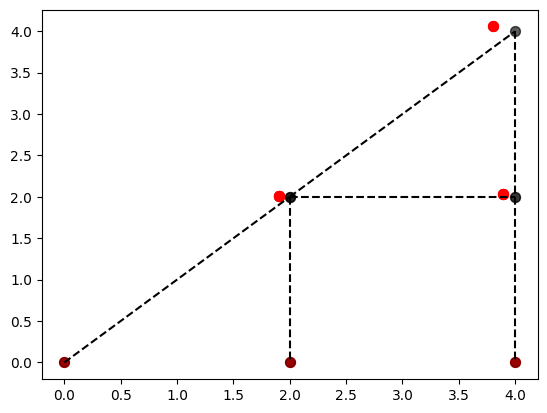

In [ ]:
esc =  1000
barra_i = 0

for barra in barras.index:
  # Nós que compoem as barras
  NO1, NO2= barras.loc[barra, ['NO1', 'NO2']]

  # Determinação das coordenadas dos nós da barra
  x1,y1 = nos.loc[NO1, ['X', 'Y']]
  x2,y2 = nos.loc[NO2, ['X', 'Y']]

  X = np.array ([x1, x2])
  Y = np.array ([y1, y2])

  # Plotando estrutura original
  plt.plot(X, Y, 'k--')

  # Adicionando os deslocamentos à posição original
  if itypestruct == 'TRELICA':
    x1d, y1d = x1+esc*d_full[LMs[barra_i][0]], y1+esc*d_full[LMs[barra_i][1]]
    x2d, y2d = x2+esc*d_full[LMs[barra_i][2]], y2+esc*d_full[LMs[barra_i][3]]
  elif itypestruct == 'PORTICO':
    x1d, y1d = x1+esc*d_full[LMs[barra_i][0]], y1+esc*d_full[LMs[barra_i][1]]
    x2d, y2d = x2+esc*d_full[LMs[barra_i][3]], y2+esc*d_full[LMs[barra_i][4]]
  elif itypestruct == 'VIGA':
    x1d, x2d = x1, x2
    y1d = y1+esc*d_full[LMs[barra_i][0]]
    y2d = y2+esc*d_full[LMs[barra_i][2]]

  plt.scatter(x1d, y1d, color='red', marker='o', s=50)
  plt.scatter(x2d, y2d, color='red', marker='o', s=50)
  plt.scatter(x1, y1, color='black', marker='o', s=50, alpha = 0.4)
  plt.scatter(x2, y2, color='black', marker='o', s=50, alpha = 0.4)

  barra_i+=1
plt.show()

##Calculando ações de extremidade finais

Calcula as ações nas extremidades finais para cada barra, a partir da matriz de rigidez local e o vetor de deslocamentos, para somar as cargas equivalentes com efeitos de deslocamentos em $A_M$.

$A_M = A_{ML} + K_L \, d$

In [ ]:
A_M = np.zeros((nnel, 2 * ndofn))
for i, ac in enumerate(A_ML):
  d_aux = np.zeros(2*ndofn)
  k = Kls[i]
  for j in range(len(ac)):
    index = LMs[i][j]
    d_aux[j] = d_full[index]
  A_M[i] = ac + np.dot(k, d_aux)

print_latex('A_M', A_M)

<IPython.core.display.Math object>

##Calculando Reações de apoio

- O vetor $f_{rl}$ contém as reações dos graus de liberdade restritos;

- Com base nos graus de liberdade livres é montada a submatriz $K_{RD}$, que associa os graus restritos com os livres a partir da matriz global de rigidez;

- O produto de $K_{RD}$ pelos deslocamentos dos nós livres, somado a $f_{rl}$, retorna o vetor com as reações de apoio $f_r$.

- $f_r = f_{rl} + K_{RD} \, {d}$

In [ ]:
f_rl = np.zeros(len(cond_cont))
index = 0

for i,j in enumerate(f):
  if i in cond_cont:
    f_rl[index] = -j
    index += 1

nos_livres = [j for j in range(ndofn*nno) if j not in cond_cont]

print_latex('f_rl', f_rl)

k_rd = np.zeros((len(cond_cont), len(nos_livres)))

cond_cont = np.sort(cond_cont)

for linha, i in enumerate(cond_cont):
    for col, j in enumerate(nos_livres):
        k_rd[linha, col] = Kg[i, j]

print()
print_latex('k_rd', k_rd)

f_r = f_rl + np.dot(k_rd, d)

print()
print_latex('f_r', f_r)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>